<a href="https://colab.research.google.com/github/nusc2016/DS-Unit-2-Kaggle-Challenge/blob/master/Module3/Turned_in_late/Aaron_Huizenga_LS_DS_223_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 3*

---

# Cross-Validation


## Assignment
- [ ] [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Continue to participate in our Kaggle challenge. 
- [ ] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


**You can't just copy** from the lesson notebook to this assignment.

- Because the lesson was **regression**, but the assignment is **classification.**
- Because the lesson used [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html), which doesn't work as-is for _multi-class_ classification.

So you will have to adapt the example, which is good real-world practice.

1. Use a model for classification, such as [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. Use hyperparameters that match the classifier, such as `randomforestclassifier__ ...`
3. Use a metric for classification, such as [`scoring='accuracy'`](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
4. If you’re doing a multi-class classification problem — such as whether a waterpump is functional, functional needs repair, or nonfunctional — then use a categorical encoding that works for multi-class classification, such as [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) (not [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html))



## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- Add your own stretch goals!
- Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/). See the previous assignment notebook for details.
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?


### BONUS: Stacking!

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [146]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [0]:
import numpy as np
import plotly.express as px
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import validation_curve
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


In [148]:
# Split the training data into training and validation dfs
train, val = train_test_split(train, train_size=0.8, test_size=0.2, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [0]:
# wrangling data on all train and test sets

def wrangle(data):
    '''Wrangle both test and train sets'''
    
    # prevent copy warning
    data = data.copy()
    
    # replace value close to zero with zeros for latitide column
    data['latitude'] = data['latitude'].replace(-2e-08, 0)
    
    # replacing zeros with nan values
    # impute with missing values later in the pipeline
    cols_with_zeros = ['latitude', 'longitude', 'population', 'amount_tsh', 'construction_year', 'num_private', 'gps_height']
    for col in cols_with_zeros:
        data[col] = data[col].replace(0, np.NaN)
        
    return data

In [150]:
train = wrangle(train)
test = wrangle(test)

train.shape, test.shape

((47520, 41), (14358, 40))

In [151]:
print(train.isnull().sum())

id                           0
amount_tsh               33265
date_recorded                0
funder                    2904
gps_height               16305
installer                 2917
longitude                 1442
latitude                  1442
wpt_name                     0
num_private              46932
basin                        0
subvillage                 286
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population               17066
public_meeting            2644
recorded_by                  0
scheme_management         3128
scheme_name              22532
permit                    2443
construction_year        16517
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [0]:
# the target for this dataset
target = 'status_group'

In [0]:
# drop duplicates
duplicate_column = (['quantity_group', 'quality_group', 
                    'waterpoint_type_group', 'extraction_type_group', 
                    'source_type', 'payment_type'])
# drop both always constant and all random columns
noneed_columns = ['recorded_by', 'id']
# adding both drop list in a new variable
unusuable_columns = duplicate_column + noneed_columns

In [0]:
# get a dataframe with all features except the target

train_features = train.drop([target] + unusuable_columns, axis=1)

In [0]:
# get a list of numeric columns

numerics_features = train_features.select_dtypes(include='number').columns.to_list()

In [0]:
# get a list of non-numeric columns

categorical_features = train_features.select_dtypes(exclude='number').columns.to_list()

In [157]:
# combine the numeric and non-numeric features

features = numerics_features + categorical_features
features

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'region_code',
 'district_code',
 'population',
 'construction_year',
 'date_recorded',
 'funder',
 'installer',
 'wpt_name',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'public_meeting',
 'scheme_management',
 'scheme_name',
 'permit',
 'extraction_type',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'water_quality',
 'quantity',
 'source',
 'source_class',
 'waterpoint_type']

In [0]:
# arranging data in X features matrix and y response vector

X_train = train[features]
y_train = train[target]
X_test = test[features]

In [159]:
X_train.shape, y_train.shape, X_test.shape

((47520, 32), (47520,), (14358, 32))

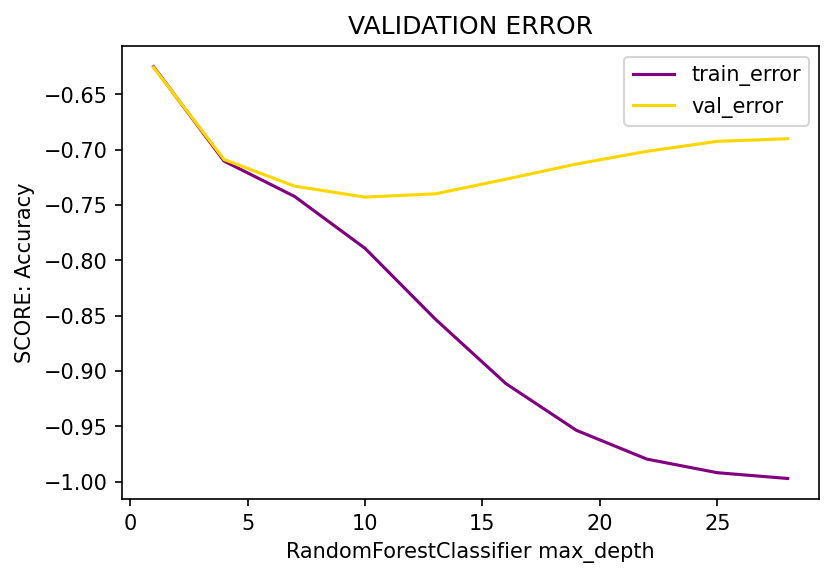

In [160]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    DecisionTreeClassifier()
)

depth = range(1, 30, 3)
train_scores, val_scores = validation_curve(
    pipeline, X_train, y_train,
    param_name='decisiontreeclassifier__max_depth', 
    param_range=depth, scoring='accuracy', 
    cv=3,
    n_jobs=-1
)



plt.figure(dpi=150)
plt.plot(depth, np.mean(-train_scores, axis=1), color='purple', label='train_error')
plt.plot(depth, np.mean(-val_scores, axis=1), color='gold', label='val_error')
plt.title('VALIDATION ERROR')
plt.xlabel('RandomForestClassifier max_depth')
plt.ylabel('SCORE: Accuracy')
plt.legend();

In [161]:
from scipy.stats import randint, uniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=42)
)

param_distributions = {
#     'ordinalencoder__min_samples_leaf': randint(1, 1000), 
#     'ordinalencoder__smoothing': uniform(1, 1000), 
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    'randomforestclassifier__max_features': uniform(0, 1), 
}



search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.4min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 17.5min


In [162]:
print('Best hyperparameters:', search.best_params_)

Best hyperparameters: {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 0.25406905841080263, 'randomforestclassifier__n_estimators': 206, 'simpleimputer__strategy': 'median'}


In [0]:
pipeline = search.best_estimator_

In [165]:
print('Validation Accuracy', pipeline.score(X_train, y_train))

Validation Accuracy 0.9735479797979798


In [0]:
X_test = test[features]

In [0]:
# I will use the next function to run a predict on test

y_pred = pipeline.predict(X_test)

In [0]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv("Aaron_Huizenga3.csv", index=False)

In [0]:
from google.colab import files
files.download('Aaron_Huizenga3.csv')